##### AI/LLM Disclosure: I used Copilot/Claude for assitance in understanding the problem, and fitting the models. However, I used my own thoughts for data exploration and verified the code is working as expected.

##### Project Objective: 
Calculate conditional probabilities of employee departure at specific tenure milestones (weeks 1-12) for different employee cohorts grouped by location (state) and job type using a Survival Model.

##### Grouping Requirements:
By Location:
 * Calculate probabilities for the top 5 states individually
 * Calculate one combined probability for all remaining states

By Job Type:
 * Calculate probabilities for each job type

Example Calculations for Week 1:
 * P(leaving | 1 week tenure AND employee from Utah)
 * P(leaving | 1 week tenure AND employee in job_type_1)
 * Continue for all top 5 states, remaining states combined, and all job types

 Repeat this analysis for weeks 2 through 12.

##### Final Dataset Structure: Your final dataset should contain these columns:

| Week number | State 1               | State 2               | State 3               | State 4               | State 5               | Rest of states        | Job type 1            | Job type 2            | Job type 3            |
|-------------|------------------------|------------------------|------------------------|------------------------|------------------------|------------------------|------------------------|------------------------|------------------------|
| 1           | conditional prob value | conditional prob value | conditional prob value | conditional prob value | conditional prob value | conditional prob value | conditional prob value | conditional prob value | conditional prob value |


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
import warnings

warnings.filterwarnings('ignore')

##### Data Exploration for df_punches & df_employees

In [2]:
# read in csvs
# punches_class.csv
# employee_class.csv
df_punches = pd.read_csv('../../datasets/punches_class.csv')
df_employees = pd.read_csv('../../datasets/employee_class.csv')

df_employees['TerminationDate'] = df_employees['TerminationDate'].replace(
    ['na', 'nan', 'NaN', 'nat', 'NaT', ''], pd.NA
)

# # Now isna() will catch them
# print(df_employees['TerminationDate'].isna())


print('df_punches:\n', df_punches.head(5))
print('df_employees:\n', df_employees.head(5))
print()

# print('df_punches:\n', df_punches.info())
# print()
# print('df_employees:\n', df_employees.info())

print()
print('df_punches shape:\n',df_punches.shape)
print('df_punches UID:\n',df_punches['ID'].nunique())
print()
print('df_employees shape:\n',df_employees.shape)
print('df_employees UID:\n',df_employees['ID'].nunique())
# okay that's good, the ID is unique here.

combined = pd.concat([df_punches, df_employees], ignore_index=True)

# Count unique IDs
unique_id_count = combined['ID'].nunique()

print(f"Number of unique IDs Between Both: {unique_id_count}")


df_punches:
                  ID rounded_date
0  f2339fa1ccaa654b   2025-03-31
1  f2339fa1ccaa654b   2025-04-01
2  f2339fa1ccaa654b   2025-04-02
3  f2339fa1ccaa654b   2025-04-03
4  f2339fa1ccaa654b   2025-04-04
df_employees:
     Hire_Date TerminationDate StateCode  Terminated Job_Type                ID
0  2021-10-20      2024-06-26        TX           1   type_2  46b728354f2aaf9f
1  2022-03-16      2022-07-25        TX           1   type_1  9dfbd0d7e8e5d86e
2  2023-09-07             NaN        FL           0   type_2  b80ee989ff51c1f4
3  2025-02-27      2025-08-08        TX           1   type_1  de6d259e880d2e36
4  2021-12-30      2022-09-01        FL           1   type_1  0c6e2dbeedbccd87


df_punches shape:
 (1653335, 2)
df_punches UID:
 23341

df_employees shape:
 (85084, 6)
df_employees UID:
 85084
Number of unique IDs Between Both: 86446


employee_class, yes = 1 for Terminated, and if they have an applicable TerminationDate there.

df_employees is completely accounted for with unique IDs which is good, while out of the 1.65 million rows in df_punches, there are only 23341 unique IDs. Oh wow. So then there really are only 1362 UIDs missing from the df_employees ID column.

I almost want to just use a COX/Kaplan-Meier model on the df_employees first to see how it does, and then try to add in the 1362 UIDs since that number may even go down further due to possible employees not being terminated.

##### Abstract

After performing the survival models on the data without adding in the 1362 other UID's from df_punches I looked at the 'class_analysis.ipynb' and the top 5 states are about the same. Only difference is the bottom two, AZ swapped with NC.

That means there are very similar results with solving this problem with Kaplan-Meier/Cox Models and solving it heuristically.


In [3]:
# checking if the Terminated and TerminationDate colums are valid.

# Ensure TerminationDate is parsed as datetime
df_employees['TerminationDate'] = pd.to_datetime(df_employees['TerminationDate'], errors='coerce')

# Check for valid terminations: Terminated == 1 AND TerminationDate is not null
valid_terminations = df_employees[(df_employees['Terminated'] == 1) & (df_employees['TerminationDate'].notna())]

# Count how many rows meet the condition
count_valid = len(valid_terminations)
total_rows = len(df_employees)

print(f"{count_valid} out of {total_rows} rows have valid termination status and date.")

# Rows that are invalid:
# Either Terminated == 1 but TerminationDate is missing
# OR Terminated == 0 but TerminationDate is present
invalid_terminations = df_employees[
    ((df_employees['Terminated'] == 1) & (df_employees['TerminationDate'].isna())) |
    ((df_employees['Terminated'] == 0) & (df_employees['TerminationDate'].notna()))
]

print("Invalid rows:")
print(invalid_terminations)
print(f"{len(invalid_terminations)} rows have inconsistent termination status/date.")

# Okay, we have verified the TerminationDate and Termination columns line up with each other, nice.

76383 out of 85084 rows have valid termination status and date.
Invalid rows:
Empty DataFrame
Columns: [Hire_Date, TerminationDate, StateCode, Terminated, Job_Type, ID]
Index: []
0 rows have inconsistent termination status/date.


##### Cox model employee_df (Naive Approach)

Event of interest: Employee termination (departure).

Time-to-event: Duration between Hire_Date and either TerminationDate (if terminated) or the censoring date (if still employed).

Censoring: Employees with Terminated == 0 and no TerminationDate are right-censored (still employed at last observation).

Covariates: StateCode, Job_Type (categorical predictors of hazard).

In [4]:
# time to do some data preparation for a cox

df_employees = pd.read_csv('../../datasets/employee_class.csv')

# Convert dates
df_employees['Hire_Date'] = pd.to_datetime(df_employees['Hire_Date'])
df_employees['TerminationDate'] = pd.to_datetime(df_employees['TerminationDate'], errors='coerce')

# Calculate duration in weeks
df_employees['duration_weeks'] = ((df_employees['TerminationDate'].fillna(pd.Timestamp.today()) - df_employees['Hire_Date']).dt.days / 7).astype(int)

# Event indicator
df_employees['event'] = df_employees['Terminated']


In [5]:
# Encode categorical variables
df_encoded = pd.get_dummies(df_employees[['duration_weeks','event','StateCode','Job_Type']], drop_first=True)

# Fit Cox model
cph = CoxPHFitter()
cph.fit(df_encoded, duration_col='duration_weeks', event_col='event')

cph.print_summary()  # hazard ratios, confidence intervals


<lifelines.CoxPHFitter: fitted with 85084 total observations, 8701 right-censored observations>
             duration col = 'duration_weeks'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 85084
number of events observed = 76383
   partial log-likelihood = -798425.56
         time fit was run = 2025-11-21 16:35:14 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
StateCode_AL    -1.51      0.22      0.71           -2.89           -0.12                0.06                0.89
StateCode_AR    -1.50      0.22      0.71           -2.89           -0.11                0.06                0.90
StateCode_AZ    -1.65      0.19      0.71           -3.03           -0.26                0.05                0.77
StateCode_CA    -1.80      0.17      0.71           -3.18           -0.41                0.04                0.66
StateCode_CO    -1.40      0.25      0.71           -2.79           -0.02                0.06                0.99
StateCode_CT    -1.70      0.18      0.71           -3.11           -0.30                0.04                0.74
StateCode_DC    -1.42      0.24      0.71           -2.82           -0.02                0.06                0.98
StateCode_DE    -1.54      0.21      0.72           -2.96           -0.12                0.05                0.89
StateCode_FL    -1.40      0.25      0.71           -2.78           -0.01                0.06                0.99
StateCode_GA    -1.38      0.25      0.71           -2.77            0.00                0.06                1.00
StateCode_HI     0.03      1.03      1.22           -2.37            2.43                0.09               11.36
StateCode_IA    -1.49      0.23      0.71           -2.88           -0.10                0.06                0.90
StateCode_ID    -1.84      0.16      0.80           -3.41           -0.26                0.03                0.77
StateCode_IL    -1.57      0.21      0.71           -2.96           -0.18                0.05                0.84
StateCode_IN    -1.72      0.18      0.71           -3.11           -0.34                0.04                0.72
StateCode_KS    -1.47      0.23      0.71           -2.86           -0.08                0.06                0.93
StateCode_KY    -1.62      0.20      0.71           -3.01           -0.23                0.05                0.79
StateCode_LA    -1.69      0.18      0.71           -3.08           -0.30                0.05                0.74
StateCode_MA    -1.70      0.18      0.71           -3.10           -0.31                0.04                0.74
StateCode_MD    -1.61      0.20      0.71           -3.00           -0.23                0.05                0.80
StateCode_ME    -1.73      0.18      0.87           -3.43           -0.04                0.03                0.97
StateCode_MI    -1.48      0.23      0.71           -2.87           -0.10                0.06                0.91
StateCode_MN    -1.78      0.17      0.71           -3.17           -0.38                0.04                0.68
StateCode_MO    -1.45      0.23      0.71           -2.84           -0.06                0.06                0.94
StateCode_MS    -1.52      0.22      0.71           -2.92           -0.12                0.05                0.88
StateCode_MT    -2.10      0.12      1.00           -4.06           -0.14                0.02                0.87
StateCode_NC    -1.57      0.21      0.71           -2.96           -0.19                0.05                0.83
StateCode_ND    -1.81      0.16      0.91           -3.60           -0.02                0.03                0.98
StateCode_NE    -1.50      0.22      0.71           -2.89           -0.10                0.06                0.90
StateCode_NH    -1.92      0.15      0.87           -3.62           -0.22                

In [6]:
# Get the columns the Cox model was trained on
expected_cols = cph.params_.index

# Build a sample row with all expected columns set to 0
sample = pd.DataFrame(0, index=[0], columns=expected_cols)

# Set the cohort you want: TX + type_1
sample['StateCode_TX'] = 1
sample['Job_Type_type_1'] = 1
sample['duration_weeks'] = 0  # starting point

survival_curve = cph.predict_survival_function(sample, times=range(1, 53))
# survival_curve.plot()


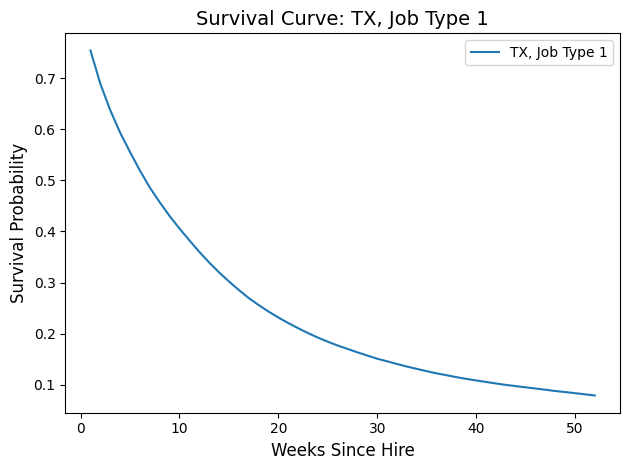

In [7]:
# Plot the survival curve for a state and job type to get a sense of how the survival probability looks
ax = survival_curve.plot()

# Add axis labels
ax.set_xlabel("Weeks Since Hire", fontsize=12)
ax.set_ylabel("Survival Probability", fontsize=12)

# Add a descriptive title
ax.set_title("Survival Curve: TX, Job Type 1", fontsize=14)

# Customize legend
ax.legend(["TX, Job Type 1"], loc="upper right")

plt.tight_layout()
plt.show()


##### Kaplan-Meier approach with employee cohorts grouped by state and job type

In [8]:
# Load data
df = pd.read_csv('../../datasets/employee_class.csv')

# Clean placeholders and parse dates
df['Hire_Date'] = pd.to_datetime(df['Hire_Date'], errors='coerce')
df['TerminationDate'] = (
    df['TerminationDate']
      .replace(['na', 'nan', 'NaN', 'nat', 'NaT', ''], pd.NA)
)
df['TerminationDate'] = pd.to_datetime(df['TerminationDate'], errors='coerce')

# Event indicator
df['event'] = (df['Terminated'] == 1).astype(int)

snapshot = pd.to_datetime('today')  # or a fixed audit date for reproducibility
df['censor_date'] = df['TerminationDate'].fillna(snapshot)

# Duration in whole weeks
df['duration_weeks'] = ((df['censor_date'] - df['Hire_Date']).dt.days // 7).clip(lower=0)

# Keep reasonable analysis window (optional)
df = df.loc[df['duration_weeks'] >= 0].copy()

# Identify top-5 states by row count
state_counts = df['StateCode'].value_counts()
top5_states = list(state_counts.head(5).index)

# Map cohorts to required labels
def state_bucket(s):
    return s if s in top5_states else 'Rest of states'

df['StateBucket'] = df['StateCode'].map(state_bucket)

# Normalize job type labels to expected names
job_types = sorted(df['Job_Type'].dropna().unique())
# Ensure consistent ordering: job_type_1, job_type_2, job_type_3 (adjust if your labels differ)


In [9]:
def km_conditional_probs(durations, events, weeks=range(0, 13)):
    kmf = KaplanMeierFitter()
    kmf.fit(durations, event_observed=events)
    # Get survival at week boundaries t=0..12
    S = kmf.survival_function_at_times(weeks).sort_index()
    # Ensure S(0)=1 for the discrete hazard calc; lifelines usually gives ~1.0
    S.iloc[0] = 1.0
    # Conditional probability for weeks 1..12: 1 - S(t)/S(t-1)
    cond = {}
    for t in range(1, 13):
        prev = S.loc[t-1]
        curr = S.loc[t]
        cond[t] = 1.0 - (curr / prev if prev > 0 else np.nan)
    return pd.Series(cond)

# Compute state-based columns
state_cols = {}
for s in top5_states:
    sub = df[df['StateBucket'] == s]
    state_cols[s] = km_conditional_probs(sub['duration_weeks'], sub['event'])

# Rest of states
sub_rest = df[df['StateBucket'] == 'Rest of states']
state_cols['Rest of states'] = km_conditional_probs(sub_rest['duration_weeks'], sub_rest['event'])

# Compute job-type columns
job_cols = {}
for jt in job_types:
    sub = df[df['Job_Type'] == jt]
    job_cols[jt] = km_conditional_probs(sub['duration_weeks'], sub['event'])

# Assemble final table: weeks 1..12 x cohorts
weeks = pd.Index(range(1, 13), name='Week number')
final_df = pd.DataFrame(index=weeks)

# Add state columns in a fixed order: top5 then rest
for i, s in enumerate(top5_states, start=1):
    final_df[f'State {i}'] = state_cols[s]
final_df['Rest of states'] = state_cols['Rest of states']

# Add job type columns in a fixed order (rename to required labels)
# Map actual job type names to "Job type 1/2/3"
jt_label_map = {jt: f'Job type {i+1}' for i, jt in enumerate(job_types)}
for jt, series in job_cols.items():
    final_df[jt_label_map[jt]] = series

# Optional: round for presentation
final_df = final_df.astype(float).round(4)

final_df


,State 1,State 2,State 3,State 4,State 5,Rest of states,Job type 1,Job type 2,Job type 3
Week number,,,,,,,,,
1,0.2510,0.2622,0.2713,0.2103,0.1984,0.2272,0.2442,0.2435,0.1930
2,0.0882,0.0969,0.0932,0.0710,0.0688,0.0724,0.0820,0.0832,0.0730
3,0.0778,0.0814,0.0758,0.0635,0.0644,0.0619,0.0664,0.0750,0.0629
4,0.0687,0.0753,0.0734,0.0596,0.0482,0.0588,0.0652,0.0664,0.0476
5,0.0667,0.0652,0.0670,0.0524,0.0480,0.0535,0.0627,0.0581,0.0509
6,0.0708,0.0654,0.0623,0.0503,0.0477,0.0560,0.0645,0.0597,0.0508
7,0.0625,0.0637,0.0600,0.0616,0.0639,0.0552,0.0597,0.0607,0.0518
8,0.0566,0.0651,0.0627,0.0444,0.0563,0.0504,0.0576,0.0540,0.0480
9,0.0599,0.0627,0.0615,0.0572,0.0423,0.0482,0.0582,0.0529,0.0482


##### Cox approach with employee cohorts grouped by state and job type

In [10]:
# One-hot encode categorical covariates (drop_first to set baselines)
cox_df = pd.get_dummies(df[['duration_weeks','event','StateBucket','Job_Type']], drop_first=True)

cph = CoxPHFitter()
cph.fit(cox_df, duration_col='duration_weeks', event_col='event')

def cox_conditional_probs(sample_row, cph_model, weeks=range(0, 13)):
    # Predict survival at week boundaries for this cohort
    S = cph_model.predict_survival_function(sample_row, times=weeks).iloc[:, 0]
    S.iloc[0] = 1.0
    cond = {}
    for t in range(1, 13):
        prev = S.loc[t-1]
        curr = S.loc[t]
        cond[t] = 1.0 - (curr / prev if prev > 0 else np.nan)
    return pd.Series(cond)

# Build sample rows with exact columns expected by the model
expected_cols = cph.params_.index

def make_sample(state_bucket, job_type):
    s = pd.DataFrame(0, index=[0], columns=expected_cols)
    # Flip chosen cohort indicators to 1
    for col in expected_cols:
        if col.startswith('StateBucket_') and col.endswith(state_bucket):
            s[col] = 1
        if col.startswith('Job_Type_') and col.endswith(job_type):
            s[col] = 1
    # duration_weeks must exist but value isn't used in prediction of S0; keep 0
    if 'duration_weeks' in s.columns:
        s['duration_weeks'] = 0
    return s

# Example: Utah (if in top5) and job_type_1
sample_utah_jt1 = make_sample('UT', 'type_1')
cox_probs = cox_conditional_probs(sample_utah_jt1, cph)


In [11]:
# Reorder columns exactly as requested
ordered_cols = (
    [f'State {i}' for i in range(1, 6)] +
    ['Rest of states', 'Job type 1', 'Job type 2', 'Job type 3']
)
# Some labels may be missing if your data has fewer than 5 states or 3 job types
final_df_present = final_df.loc[:, [c for c in ordered_cols if c in final_df.columns]]

# View as a Pandas table
final_df_present

# Produce Markdown for a notebook Markdown cell
md_table = final_df_present.reset_index().to_markdown(index=False)
print(md_table)


|   Week number |   State 1 |   State 2 |   State 3 |   State 4 |   State 5 |   Rest of states |   Job type 1 |   Job type 2 |   Job type 3 |
|--------------:|----------:|----------:|----------:|----------:|----------:|-----------------:|-------------:|-------------:|-------------:|
|             1 |    0.251  |    0.2622 |    0.2713 |    0.2103 |    0.1984 |           0.2272 |       0.2442 |       0.2435 |       0.193  |
|             2 |    0.0882 |    0.0969 |    0.0932 |    0.071  |    0.0688 |           0.0724 |       0.082  |       0.0832 |       0.073  |
|             3 |    0.0778 |    0.0814 |    0.0758 |    0.0635 |    0.0644 |           0.0619 |       0.0664 |       0.075  |       0.0629 |
|             4 |    0.0687 |    0.0753 |    0.0734 |    0.0596 |    0.0482 |           0.0588 |       0.0652 |       0.0664 |       0.0476 |
|             5 |    0.0667 |    0.0652 |    0.067  |    0.0524 |    0.048  |           0.0535 |       0.0627 |       0.0581 |       0.0509 |
|     

In [12]:
state_label_map = {f'State {i}': s for i, s in enumerate(top5_states, start=1)}
state_label_map  # e.g., {'State 1': 'TX', 'State 2': 'FL', ...}

{'State 1': 'TX',
 'State 2': 'FL',
 'State 3': 'GA',
 'State 4': 'NC',
 'State 5': 'AZ'}

In [13]:

# ------------------------------
# 1) Load and clean data
# ------------------------------
df = pd.read_csv('../../datasets/employee_class.csv')

# Convert dates
df["Hire_Date"] = pd.to_datetime(df["Hire_Date"])
df["TerminationDate"] = pd.to_datetime(df["TerminationDate"], errors="coerce")

# Calculate tenure in weeks
today = pd.Timestamp.today()
df["End_Date"] = df["TerminationDate"].fillna(today)
df["time"] = (df["End_Date"] - df["Hire_Date"]).dt.days // 7
df["event"] = df["Terminated"]

# ------------------------------
# 2) Group states
# ------------------------------
top5_states = df["StateCode"].value_counts().index[:5].tolist()
df["state_group"] = np.where(df["StateCode"].isin(top5_states),
                             df["StateCode"], "Rest")

# ------------------------------
# 3) Encode categorical variables
# ------------------------------
X_state = pd.get_dummies(df["state_group"], prefix="state", drop_first=True)
X_job = pd.get_dummies(df["Job_Type"], prefix="job", drop_first=True)

X = pd.concat([X_state, X_job], axis=1)
df_fit = pd.concat([df[["time", "event"]], X], axis=1)

# ------------------------------
# 4) Fit Cox model
# ------------------------------
cph = CoxPHFitter()
cph.fit(df_fit, duration_col="time", event_col="event")

baseline_surv = cph.baseline_survival_
beta = cph.params_

# ------------------------------
# 5) Helper function
# ------------------------------
def survival_curve(cov_vector, time_points):
    x_vec = pd.Series(0.0, index=beta.index)
    for k, v in cov_vector.items():
        if k in x_vec.index:
            x_vec[k] = v
    eta = np.dot(beta.values, x_vec.values)
    S0 = baseline_surv.reindex(time_points, method="ffill")["baseline survival"].values
    return S0 ** np.exp(eta)

# ------------------------------
# 6) Compute conditional probs
# ------------------------------
weeks = np.arange(1, 13)
weeks_next = np.arange(2, 14)

results = pd.DataFrame({"Week number": weeks})

# States
for s in top5_states + ["Rest"]:
    cov = {col: 0.0 for col in X_state.columns}
    colname = f"state_{s}"
    if colname in cov:
        cov[colname] = 1.0
    S_t = survival_curve(cov, weeks)
    S_t1 = survival_curve(cov, weeks_next)
    results[s] = 1 - (S_t1 / S_t)

# Job types
for j in df["Job_Type"].unique():
    cov = {col: 0.0 for col in X_job.columns}
    colname = f"job_{j}"
    if colname in cov:
        cov[colname] = 1.0
    S_t = survival_curve(cov, weeks)
    S_t1 = survival_curve(cov, weeks_next)
    results[j] = 1 - (S_t1 / S_t)

# ------------------------------
# 7) Final dataset
# ------------------------------
print(results)


    Week number        TX        FL        GA        NC        AZ      Rest  \
0             1  0.096186  0.099183  0.100247  0.083745  0.078607  0.083875   
1             2  0.083488  0.086109  0.087040  0.072624  0.068142  0.072737   
2             3  0.076782  0.079202  0.080061  0.066758  0.062626  0.066863   
3             4  0.070995  0.073239  0.074036  0.061701  0.057872  0.061797   
4             5  0.072832  0.075132  0.075949  0.063306  0.059381  0.063405   
5             6  0.071234  0.073486  0.074286  0.061910  0.058069  0.062007   
6             7  0.065916  0.068005  0.068748  0.057266  0.053705  0.057356   
7             8  0.065626  0.067707  0.068446  0.057013  0.053467  0.057103   
8             9  0.063381  0.065393  0.066108  0.055054  0.051626  0.055141   
9            10  0.063257  0.065265  0.065979  0.054946  0.051525  0.055032   
10           11  0.065441  0.067516  0.068254  0.056852  0.053316  0.056941   
11           12  0.064311  0.066351  0.067076  0.055

##### Kaplan-Meier approach #2 with employee cohorts grouped by state and job type

In [14]:
# Load your data
df = pd.read_csv('../../datasets/employee_class.csv')

# Convert dates to datetime
df['Hire_Date'] = pd.to_datetime(df['Hire_Date'])
# df['TerminationDate'] = pd.to_datetime(df['TerminationDate'])

df['TerminationDate'] = (
    df['TerminationDate']
      .replace(['na', 'nan', 'NaN', 'nat', 'NaT', ''], pd.NA)
)
df['TerminationDate'] = pd.to_datetime(df['TerminationDate'], errors='coerce')


# Calculate tenure in weeks
current_date = pd.Timestamp.now()
df['tenure_weeks'] = np.where(
    df['Terminated'] == 1,
    (df['TerminationDate'] - df['Hire_Date']).dt.days / 7,
    (current_date - df['Hire_Date']).dt.days / 7
)

# Round to integer weeks
df['tenure_weeks'] = df['tenure_weeks'].round().astype(int)

# Ensure minimum tenure of 1 week and cap at 12 weeks for this analysis
df['tenure_weeks'] = df['tenure_weeks'].clip(lower=1, upper=52)

print("Data Summary:")
print(f"Total employees: {len(df)}")
print(f"Terminated: {df['Terminated'].sum()}")
print(f"Active: {(1-df['Terminated']).sum()}")
print(f"\nTenure range: {df['tenure_weeks'].min()} to {df['tenure_weeks'].max()} weeks")

# Identify top 5 states
top_states = df['StateCode'].value_counts().head(5).index.tolist()
print(f"\nTop 5 states: {top_states}")

# Create 'Rest of States' category
df['State_Category'] = df['StateCode'].apply(
    lambda x: x if x in top_states else 'Rest_of_States'
)

# Get all job types
job_types = df['Job_Type'].unique().tolist()
print(f"Job types: {job_types}")

def calculate_conditional_probabilities_km(df, group_col, group_value, weeks=12):
    """
    Calculate conditional probabilities using Kaplan-Meier estimator.
    Conditional probability = P(leave at week t | survived to week t)
    """
    # Filter data for specific group
    group_data = df[df[group_col] == group_value].copy()
    
    if len(group_data) == 0:
        return {i: np.nan for i in range(1, weeks + 1)}
    
    # Fit Kaplan-Meier
    kmf = KaplanMeierFitter()
    kmf.fit(
        durations=group_data['tenure_weeks'],
        event_observed=group_data['Terminated'],
        timeline=range(1, weeks + 1)
    )
    
    # Calculate conditional probabilities
    conditional_probs = {}
    
    for week in range(1, weeks + 1):
        # Survival probability at week-1 and week
        s_prev = kmf.survival_function_at_times(week - 1).values[0] if week > 1 else 1.0
        s_curr = kmf.survival_function_at_times(week).values[0]
        
        # Conditional probability = (S(t-1) - S(t)) / S(t-1)
        if s_prev > 0:
            conditional_probs[week] = (s_prev - s_curr) / s_prev
        else:
            conditional_probs[week] = 0.0
    
    return conditional_probs

# Calculate conditional probabilities for each state category
print("\nCalculating conditional probabilities by state...")
state_probs = {}

for state in top_states:
    print(f"  Processing: {state}")
    state_probs[state] = calculate_conditional_probabilities_km(
        df, 'State_Category', state
    )

# Calculate for 'Rest of States'
print(f"  Processing: Rest_of_States")
state_probs['Rest_of_States'] = calculate_conditional_probabilities_km(
    df, 'State_Category', 'Rest_of_States'
)

# Calculate conditional probabilities for each job type
print("\nCalculating conditional probabilities by job type...")
job_probs = {}

for job_type in job_types:
    print(f"  Processing: {job_type}")
    job_probs[job_type] = calculate_conditional_probabilities_km(
        df, 'Job_Type', job_type
    )

# Build final results dataframe
results_data = {'Week': list(range(1, 13))}

# Add state columns
for state in top_states:
    results_data[state] = [state_probs[state][week] for week in range(1, 13)]

results_data['Rest_of_States'] = [
    state_probs['Rest_of_States'][week] for week in range(1, 13)
]

# Add job type columns
for job_type in job_types:
    results_data[job_type] = [job_probs[job_type][week] for week in range(1, 13)]

# Create final dataframe
results_df = pd.DataFrame(results_data)

print("\n" + "="*80)
print("FINAL RESULTS: Conditional Probabilities of Departure by Week")
print("="*80)
print("\nConditional Probability = P(leaving at week t | survived to week t)")
print("\nInterpretation: For employees who have survived to week X,")
print("what is the probability they leave during that week?\n")

# Format for display
display_df = results_df.copy()
for col in display_df.columns:
    if col != 'Week':
        display_df[col] = display_df[col].apply(lambda x: f'{x:.4f}' if not pd.isna(x) else 'N/A')

print(display_df.to_string(index=False))

# Additional insights
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

for state in top_states + ['Rest_of_States']:
    avg_prob = np.nanmean([state_probs[state][w] for w in range(1, 13)])
    print(f"\n{state}:")
    print(f"  Average conditional departure probability (weeks 1-12): {avg_prob:.4f}")
    print(f"  Highest risk week: Week {max(state_probs[state], key=state_probs[state].get)}")

for job_type in job_types:
    avg_prob = np.nanmean([job_probs[job_type][w] for w in range(1, 13)])
    print(f"\n{job_type}:")
    print(f"  Average conditional departure probability (weeks 1-12): {avg_prob:.4f}")
    print(f"  Highest risk week: Week {max(job_probs[job_type], key=job_probs[job_type].get)}")


Data Summary:
Total employees: 85084
Terminated: 76383
Active: 8701

Tenure range: 1 to 52 weeks

Top 5 states: ['TX', 'FL', 'GA', 'NC', 'AZ']
Job types: ['type_2', 'type_1', 'type_3']

Calculating conditional probabilities by state...
  Processing: TX
  Processing: FL
  Processing: GA
  Processing: NC
  Processing: AZ
  Processing: Rest_of_States

Calculating conditional probabilities by job type...
  Processing: type_2
  Processing: type_1
  Processing: type_3

FINAL RESULTS: Conditional Probabilities of Departure by Week

Conditional Probability = P(leaving at week t | survived to week t)

Interpretation: For employees who have survived to week X,
what is the probability they leave during that week?

 Week     TX     FL     GA     NC     AZ Rest_of_States type_2 type_1 type_3
    1 0.2131 0.2215 0.2388 0.1753 0.1647         0.1891 0.2046 0.2078 0.1585
    2 0.0962 0.1054 0.0967 0.0825 0.0776         0.0882 0.0951 0.0918 0.0836
    3 0.0817 0.0885 0.0836 0.0669 0.0673         0.0650 

##### All Results

Claude Assisted Kaplan-Meier:
|   Week number |      TX |      FL |      GA |      NC |      AZ |   Rest of states |   Job type 1 |   Job type 2 |   Job type 3 |
|--------------:|--------:|--------:|--------:|--------:|--------:|-----------------:|-------------:|-------------:|-------------:|
|             1 | 0.21310 | 0.22150 | 0.23880 | 0.17530 | 0.16470 |          0.18910 |      0.20780 |      0.20460 |      0.15850 |
|             2 | 0.09620 | 0.10540 | 0.09670 | 0.08250 | 0.07760 |          0.08820 |      0.09180 |      0.09510 |      0.08360 |
|             3 | 0.08170 | 0.08850 | 0.08360 | 0.06690 | 0.06730 |          0.06500 |      0.07260 |      0.07810 |      0.06650 |
|             4 | 0.07330 | 0.07530 | 0.07020 | 0.06050 | 0.05460 |          0.06030 |      0.06520 |      0.06960 |      0.05340 |
|             5 | 0.06630 | 0.07300 | 0.07330 | 0.05050 | 0.05140 |          0.05380 |      0.06210 |      0.06200 |      0.05110 |
|             6 | 0.07100 | 0.06340 | 0.05840 | 0.05640 | 0.04520 |          0.05430 |      0.06420 |      0.05820 |      0.05100 |
|             7 | 0.06560 | 0.06190 | 0.06360 | 0.05560 | 0.06010 |          0.05720 |      0.06340 |      0.06020 |      0.04810 |
|             8 | 0.05950 | 0.06640 | 0.06210 | 0.05570 | 0.06120 |          0.05490 |      0.06050 |      0.05890 |      0.04680 |
|             9 | 0.05690 | 0.06470 | 0.06550 | 0.04730 | 0.04290 |          0.04860 |      0.05640 |      0.05270 |      0.05140 |
|            10 | 0.05870 | 0.06130 | 0.05800 | 0.05400 | 0.04890 |          0.04810 |      0.05890 |      0.05130 |      0.04550 |
|            11 | 0.05280 | 0.05680 | 0.05930 | 0.04610 | 0.05360 |          0.05190 |      0.05450 |      0.05250 |      0.04930 |
|            12 | 0.05210 | 0.06110 | 0.05550 | 0.05430 | 0.05050 |          0.05230 |      0.05720 |      0.05190 |      0.04670 |


Copilot Assisted Kaplan-Meier:
|   Week number |   TX |   FL |   GA |   NC |   AZ |   Rest of states |   Job type 1 |   Job type 2 |   Job type 3 |
|--------------:|----------:|----------:|----------:|----------:|----------:|-----------------:|-------------:|-------------:|-------------:|
|             1 |    0.251  |    0.2622 |    0.2713 |    0.2103 |    0.1984 |           0.2272 |       0.2442 |       0.2435 |       0.193  |
|             2 |    0.0882 |    0.0969 |    0.0932 |    0.071  |    0.0688 |           0.0724 |       0.082  |       0.0832 |       0.073  |
|             3 |    0.0778 |    0.0814 |    0.0758 |    0.0635 |    0.0644 |           0.0619 |       0.0664 |       0.075  |       0.0629 |
|             4 |    0.0687 |    0.0753 |    0.0734 |    0.0596 |    0.0482 |           0.0588 |       0.0652 |       0.0664 |       0.0476 |
|             5 |    0.0668 |    0.0655 |    0.0673 |    0.0526 |    0.0482 |           0.0537 |       0.063  |       0.0583 |       0.0511 |
|             6 |    0.071  |    0.0658 |    0.0625 |    0.0506 |    0.048  |           0.0562 |       0.0647 |       0.06   |       0.0511 |
|             7 |    0.0627 |    0.064  |    0.0601 |    0.0619 |    0.0641 |           0.0555 |       0.0599 |       0.061  |       0.052  |
|             8 |    0.0568 |    0.0654 |    0.0627 |    0.0445 |    0.0565 |           0.0506 |       0.0578 |       0.0542 |       0.0481 |
|             9 |    0.0601 |    0.063  |    0.0617 |    0.0573 |    0.0425 |           0.0485 |       0.0584 |       0.0531 |       0.0484 |
|            10 |    0.0531 |    0.0581 |    0.0596 |    0.0468 |    0.0528 |           0.0508 |       0.0569 |       0.051  |       0.0438 |
|            11 |    0.0516 |    0.0604 |    0.0587 |    0.0528 |    0.0516 |           0.05   |       0.0549 |       0.0512 |       0.0526 |
|            12 |    0.0568 |    0.0586 |    0.0567 |    0.0531 |    0.0446 |           0.0531 |       0.0593 |       0.0526 |       0.0425 |

Copilot Assisted Cox Model:
|   Week number |      TX |      FL |      GA |      NC |      AZ |      Rest |   Job type 1 |   Job type 2 |   Job type 3 |
|--------------:|--------:|--------:|--------:|--------:|--------:|----------:|-------------:|-------------:|-------------:|
|             1 | 0.09611 | 0.09917 | 0.10016 | 0.08369 | 0.07861 |   0.08385 |      0.07861 |      0.07510 |      0.06591 |
|             2 | 0.08342 | 0.08610 | 0.08696 | 0.07258 | 0.06814 |   0.07271 |      0.06814 |      0.06508 |      0.05709 |
|             3 | 0.07672 | 0.07919 | 0.07999 | 0.06671 | 0.06263 |   0.06684 |      0.06263 |      0.05981 |      0.05244 |
|             4 | 0.07119 | 0.07349 | 0.07423 | 0.06188 | 0.05808 |   0.06199 |      0.05808 |      0.05546 |      0.04861 |
|             5 | 0.07307 | 0.07542 | 0.07619 | 0.06352 | 0.05962 |   0.06364 |      0.05962 |      0.05693 |      0.04991 |
|             6 | 0.07143 | 0.07373 | 0.07448 | 0.06209 | 0.05827 |   0.06221 |      0.05827 |      0.05565 |      0.04878 |
|             7 | 0.06611 | 0.06825 | 0.06894 | 0.05744 | 0.05391 |   0.05755 |      0.05391 |      0.05147 |      0.04511 |
|             8 | 0.06582 | 0.06796 | 0.06865 | 0.05719 | 0.05367 |   0.05730 |      0.05367 |      0.05124 |      0.04491 |
|             9 | 0.06350 | 0.06555 | 0.06622 | 0.05516 | 0.05176 |   0.05527 |      0.05176 |      0.04942 |      0.04330 |
|            10 | 0.06337 | 0.06542 | 0.06609 | 0.05505 | 0.05166 |   0.05516 |      0.05166 |      0.04932 |      0.04321 |
|            11 | 0.06554 | 0.06767 | 0.06836 | 0.05695 | 0.05344 |   0.05706 |      0.05344 |      0.05103 |      0.04471 |
|            12 | 0.06442 | 0.06650 | 0.06718 | 0.05597 | 0.05252 |   0.05607 |      0.05252 |      0.05014 |      0.04394 |


##### Conclusion
After checking my results with the class_analysis.ipynb file the difference is only between AZ, and NC. This means utilizing Cox models, or Kaplan-Meier models shows similar performance to when the problem is solved heuristically. That's pretty cool, and another thing that is neat is that from prior data exploration, I found there were only 1200 missing unique IDs in the employee dataset in comparison to the punches dataset. I thought since there were about 80,000 unique IDs that the 1300 IDs from the other dataset wouldn't impact results to much and it seems like it was a correct assumption since results really didn't change much.
Also, I think it is apparent that the first week is the most volatile for turn-over rate. It seems for both the Cox model and Kaplan-Meier models shows that the first week had the highest potential termination.